# TDEM Magnetic Dipole Sounding over a Sphere

In this notebook, we will simulate an TDEM sounding over a conductive sphere. A cylindrical mesh and the [SimPEG](http://simpeg.xyz) Electromanetics module is used to perform the simulation. 

For more on SimPEG and SimPEG.EM see:

- [(Cockett et al., 2015)](http://www.sciencedirect.com/science/article/pii/S009830041530056X): *SimPEG: An open source framework for simulation and gradient based parameter estimation in geophysical applications*
- [(Heagy et al., 2016)](https://arxiv.org/abs/1610.00804): *A framework for simulation and inversion in electromagnetics*


## Setup

An inductive loop transmitter is centered over an electrically conductive sphere (radius 30m). The transmitter is 20m above the surface, and the center of the sphere is 50m below the surface. A coil receiver is offset by 8m horizontally from the transmitter. 

<img src="https://raw.githubusercontent.com/simpeg/em_notebooks/master/images/cylsetup.png" width=60%>

## Getting Started: Package Imports

- [NumPy](http://www.numpy.org/), [SciPy](https://www.scipy.org/) and [Matplotlib](http://matplotlib.org/) are core Python packages that can be installed when you install python with a distribution such as [Anaconda](https://www.continuum.io/downloads). 

- [SimPEG](http://simpeg.xyz) is a Simulation and Inversion package for geophysics

If you would like to set up and run SimPEG on your machine, see http://simpeg.xyz and http://tutorials.simpeg.xyz

In [1]:
# Basic python packages
import numpy as np 
import matplotlib.pyplot as plt
from scipy.constants import mu_0

# Modules of SimPEG we will use for forward modelling
from SimPEG import Mesh, Utils, Maps
from SimPEG.EM import TDEM
from SimPEG import SolverLU as Solver

# Set a nice colormap! 
plt.set_cmap(plt.get_cmap('viridis'))

%matplotlib inline

## Model Parameters

We define a 
- resistive halfspace and 
- conductive sphere 
   - radius of 30m 
   - center is 50m below the surface

In [2]:
# electrical conductivities in S/m
sig_halfspace = 1e-6
sig_sphere = 1e-2
sig_air = 1e-8

In [3]:
# depth to center, radius in m
sphere_z = -50.
sphere_radius = 30. 

## Survey Parameters

- Transmitter and receiver 20m above the surface 
- Receiver offset from transmitter by 8m horizontally
- We will sample 30 times from $10^{-7}$s to $10^{-4}$s

In [4]:
tx_height = 20. 
rx_offset = 8. 

times = np.logspace(-7, -4, 30)

# source and receiver location in 3D space
src_loc = np.r_[0., 0., tx_height]
rx_loc = np.atleast_2d(np.r_[rx_offset, 0., tx_height])

In [5]:
# print the min and max diffusion distances to make sure mesh is 
# fine enough and extends far enough 

def diffusion_distance(sigma, time):
    return 1.28*np.sqrt(time/(sigma * mu_0))

print(
    'min diffusion distance: {:.2e} m'.format(diffusion_distance(sig_sphere, times.min()))
)
print(
    'max diffusion distance: {:.2e} m'.format(diffusion_distance(sig_halfspace, times.max()))
)

min diffusion distance: 3.61e+00 m
max diffusion distance: 1.14e+04 m


## Mesh

Here, we define a cylindrically symmetric tensor mesh. 

The figure below shows a cell in a cartesian mesh (a) and a cylindrically symmetric mesh (b). Note that edges are rotational and faces are radial and vertical in the cylindrically symmetric mesh. 

<img src="https://raw.githubusercontent.com/simpeg/em_notebooks/master/images/finiteVolume-02.png" width=60%>

### Mesh Parameters

For the mesh, we will use a cylindrically symmetric tensor mesh. To construct a tensor mesh, all that is needed is a vector of cell widths in the x and z-directions. We will define a core mesh region of uniform cell widths and a padding region where the cell widths expand "to infinity". 

In [6]:
# x-direction
csx = 2  # core mesh cell width in the x-direction
ncx = np.ceil(1.2*sphere_radius/csx)  # number of core x-cells (uniform mesh slightly beyond sphere radius)
npadx = 30  # number of x padding cells

# z-direction
csz = 1  # core mesh cell width in the z-direction
ncz = np.ceil(1.2*(tx_height - (sphere_z-sphere_radius))/csz) # number of core z-cells (uniform cells slightly below bottom of sphere)
npadz = 32  # number of z padding cells

# padding factor (expand cells to infinity)
pf = 1.3

In [7]:
# cell spacings in the x and z directions
hx = Utils.meshTensor([(csx, ncx), (csx, npadx, pf)])
hz = Utils.meshTensor([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])

# define a SimPEG mesh
mesh = Mesh.CylMesh([hx, 1, hz], x0 = np.r_[0.,0., -hz.sum()/2.-tx_height])

In [8]:
print hx

[  2.00000000e+00   2.00000000e+00   2.00000000e+00   2.00000000e+00
   2.00000000e+00   2.00000000e+00   2.00000000e+00   2.00000000e+00
   2.00000000e+00   2.00000000e+00   2.00000000e+00   2.00000000e+00
   2.00000000e+00   2.00000000e+00   2.00000000e+00   2.00000000e+00
   2.00000000e+00   2.00000000e+00   2.60000000e+00   3.38000000e+00
   4.39400000e+00   5.71220000e+00   7.42586000e+00   9.65361800e+00
   1.25497034e+01   1.63146144e+01   2.12089987e+01   2.75716984e+01
   3.58432079e+01   4.65961702e+01   6.05750213e+01   7.87475277e+01
   1.02371786e+02   1.33083322e+02   1.73008318e+02   2.24910814e+02
   2.92384058e+02   3.80099275e+02   4.94129058e+02   6.42367776e+02
   8.35078108e+02   1.08560154e+03   1.41128200e+03   1.83466660e+03
   2.38506659e+03   3.10058656e+03   4.03076253e+03   5.23999129e+03]


### Plot the mesh

Below, we plot the mesh. The cyl mesh is rotated around x=0. Ensure that each dimension extends beyond the maximum skin depth. 

Zoom in by changing the xlim and zlim. 

The maximum diffusion distance (in background) is: 1.14e+04 m. Does the mesh go sufficiently past that?


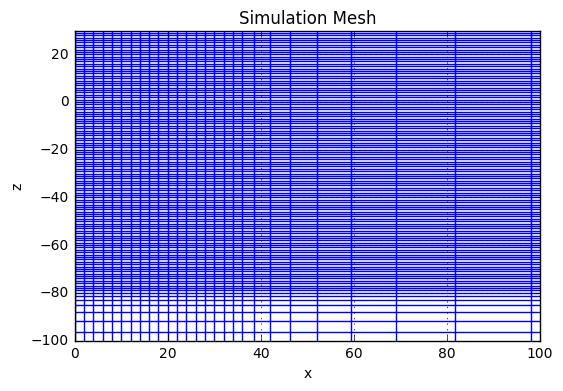

In [10]:
# X and Z limits we want to plot to. Try 
xlim = np.r_[0., 100]
zlim = np.r_[-100, 30]

fig, ax = plt.subplots(1,1)
mesh.plotGrid(ax=ax)

ax.set_title('Simulation Mesh')
ax.set_xlim(xlim)
ax.set_ylim(zlim)

print(
    'The maximum diffusion distance (in background) is: {:.2e} m. '
    'Does the mesh go sufficiently past that?'.format(
        diffusion_distance(sig_halfspace, times.max())
    )
)

## Put Model on Mesh

Now that the model parameters and mesh are defined, we can define electrical conductivity on the mesh. 

The electrical conductivity is defined at cell centers when using the finite volume method. So here, we define a vector that contains an electrical conductivity value for every cell center. 

In [11]:
# create a vector that has one entry for every cell center
sigma = sig_air*np.ones(mesh.nC)  # start by defining the conductivity of the air everwhere
sigma[mesh.gridCC[:,2] < 0.] = sig_halfspace  # assign halfspace cells below the earth

sigma_background = sigma.copy()

# indices of the sphere (where (x-x0)**2 + (z-z0)**2 <= R**2)
sphere_ind = (mesh.gridCC[:,0]**2 + (mesh.gridCC[:,2] - sphere_z)**2) <= sphere_radius**2 
sigma[sphere_ind] = sig_sphere  # assign the conductivity of the sphere

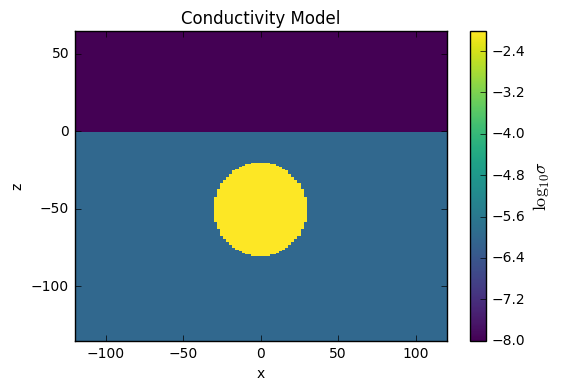

In [12]:
# Plot a cross section of the conductivity model
fig, ax = plt.subplots(1,1)
cb = plt.colorbar(mesh.plotImage(np.log10(sigma), ax=ax, mirror=True)[0])

# plot formatting and titles
cb.set_label('$\log_{10}\sigma$', fontsize=13)
ax.axis('equal')
ax.set_xlim([-120., 120.])
ax.set_ylim([-100., 30.])
ax.set_title('Conductivity Model')

## Set up the Survey

Here, we define sources and receivers. For this example, the receivers sample $db/dt$, the time-derivative of the magnetic flux. The source is a vertical magnetic dipole with unit moment. 

In [14]:
# Define the receivers, we will sample the real secondary magnetic flux density as well as the 
# imaginary magnetic flux density 

dbdt_z = TDEM.Rx.Point_dbdt(locs=rx_loc, times=times, orientation='z')  # vertical db_dt
rxList = [dbdt_z]  # list of receivers

In [15]:
# Define the list of sources - one source for each frequency. The source is a point dipole oriented
# in the z-direction

srcList = [
    TDEM.Src.MagDipole(
        rxList, loc=src_loc, orientation='z', waveform=TDEM.Src.StepOffWaveform()
    )
]

print(
    'There is {nsrc} source. Each source has {nrx} receivers '
    'sampling the resulting db/dt-field at {ntimes} times'.format(
        nsrc = len(srcList), 
        nrx = len(rxList),
        ntimes = len(times)
    )
)

There is 1 source. Each source has 1 receivers sampling the resulting db/dt-field at 30 times


## Set up Forward Simulation 

A forward simulation consists of a paired SimPEG problem and Survey. For this example, we use the E-formulation of Maxwell's equations, solving the second-order system for the electric field, which is defined on the cell edges of the mesh. This is the `prob` variable below. The `survey` takes the source list which is used to construct the RHS for the problem. The source list also contains the receiver information, so the `survey` knows how to sample fields and fluxes that are produced by solving the `prob`.



**An Aside: Mappings** 

The `sigmaMap` defines a [mapping](http://dev-docs.simpeg.xyz/content/api_core/api_Maps.html) which translates an input vector to a physical property - specifically, $\sigma$. This comes in handy when you want to invert for $\log(\sigma)$, in that case, the model is defined in terms of log-conductivity, and you would need an `ExpMap` to translate $\log(\sigma) \to \sigma$

In [16]:
# solve the problem at these times
timeSteps = [(1e-8, 20), (1e-7, 20), (2e-7, 10), (1e-6, 10), (2e-6, 10), (1e-5, 10)] 

# define a problem - the statement of which discrete pde system we want to solve
prob = TDEM.Problem3D_e(mesh, timeSteps = timeSteps, sigmaMap=Maps.IdentityMap(mesh))  
prob.solver = Solver

survey = TDEM.Survey(srcList)

# tell the problem and survey about each other - so the RHS can be constructed for 
# the problem and the resulting fields and fluxes can be sampled by the receiver. 
prob.pair(survey)  

print('The maximum time is {:1.1e}'.format(prob.times[-1]))

The maximum time is 1.3e-04


### Solve the forward simulation 

Here, we solve the problem for the fields everywhere on the mesh, for with and without the sphere. 

In [17]:
%%time
print('solving with sphere ... ')
fields = prob.fields(sigma)
print('... done ')

solving with sphere ... 
... done 
CPU times: user 5.25 s, sys: 210 ms, total: 5.46 s
Wall time: 2.93 s


In [18]:
%%time
print('solving without sphere ... ')
fields_background = prob.fields(sigma_background)
print('... done ')

solving without sphere ... 
... done 
CPU times: user 5.3 s, sys: 218 ms, total: 5.52 s
Wall time: 3.13 s


### Plot the fields

Lets look at the physics!

In [19]:
# log-scale the colorbar
from matplotlib.colors import LogNorm 
import ipywidgets

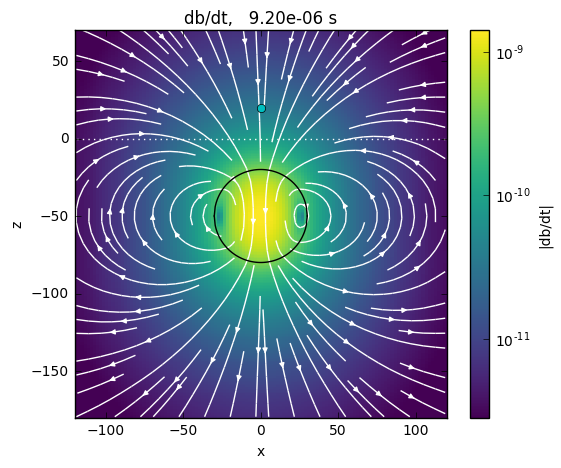

In [20]:
def plot_dbdtSphere(
    time_ind=0 # which frequency would you like to look at?
#     ax=ax
):
    fig, ax = plt.subplots(1,1, figsize=(6,5))
    
    # Plot the magnetic flux
    field_to_plot = fields[srcList, 'dbdt', time_ind]
    max_field = np.abs(field_to_plot).max() #use to set colorbar limits
    cb_range = 5e2  # dynamic range of colorbar
    
    cb = plt.colorbar(mesh.plotImage(
        field_to_plot, 
        vType='F', view='vec', 
        range_x=[-120., 120.], range_y=[-180., 80.],
        pcolorOpts={
                'norm': LogNorm(), 
                'cmap': plt.get_cmap('viridis')
            },
        streamOpts={'color': 'w'}, mirror=True, ax=ax, 
        clim=[max_field/cb_range, max_field]
    )[0], ax=ax)

    ax.set_xlim([-120., 120.])
    ax.set_ylim([-180., 70.])
    cb.set_label('|db/dt|')

    # plot the outline of the sphere
    x = np.linspace(-sphere_radius, sphere_radius, 100)
    ax.plot(x, np.sqrt(sphere_radius**2 - x**2) + sphere_z, color='k')
    ax.plot(x, -np.sqrt(sphere_radius**2 - x**2) + sphere_z, color='k')

    # plot the source and receiver locations
    ax.plot(src_loc[0],src_loc[2],'co', markersize=6)
    # ax.plot(rx_loc[0,0],rx_loc[0,2],'co', markersize=6)

    # plot the surface of the earth
    ax.plot(np.r_[-200, 200], np.r_[0., 0.], 'w:')

    # give it a title
    ax.set_title(
        'db/dt, {time:10.2e} s'.format( 
            time=prob.times[time_ind]
        )
    )
    plt.show()
    return ax

ipywidgets.interact(
    plot_dbdtSphere, 
    time_ind=ipywidgets.IntSlider(min=1, max=len(prob.timeSteps)-1, value=1) 
)

### Plot data with and without sphere

In what follows, we plot db/dt data with and without the sphere

In [21]:
dpred = survey.dpred(sigma, f=fields)
dpred_background = survey.dpred(sigma_background, f=fields_background)

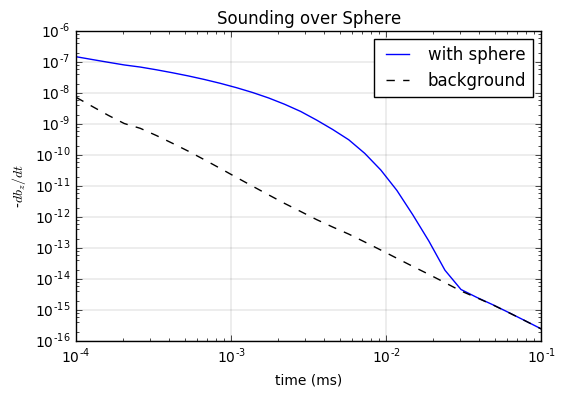

In [22]:
# Plot
fig, ax = plt.subplots(1,1)

ax.loglog(1e3*times, -dpred)
ax.loglog(1e3*times, -dpred_background, '--k')
ax.grid(True, color='k',linestyle="-", linewidth=0.1)
ax.legend(['with sphere', 'background'])

ax.set_title('Sounding over Sphere')
ax.set_ylabel('-$db_z/dt$')
ax.set_xlabel('time (ms)')